In [91]:
# Notebook for homework module 4 : Evaluation

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score,accuracy_score, precision_score,recall_score,f1_score,auc,roc_curve
from sklearn.feature_extraction import DictVectorizer

In [93]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [94]:
# get the description of the dataset:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [96]:
# check for missing  values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [97]:
# get the categorical and numeric variables
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns =  list(df.dtypes[df.dtypes != 'object'].index)
print(f"the Categorical colunms are: {categorical_columns}\n")
print(f"the Numerical columns are: {numerical_columns}")

the Categorical colunms are: ['lead_source', 'industry', 'employment_status', 'location']

the Numerical columns are: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [98]:
df[categorical_columns] = df[categorical_columns].fillna("NA")
df[numerical_columns] = df[numerical_columns].fillna(0.0)
#double check for missing values
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [99]:
# split the dataset into train, validation, and test sets 60,20,20
train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

In [100]:
train_shape= round(train.shape[0]/len(df),2)*100
val_shape= round(val.shape[0]/len(df),2)*100
test_shape= round(test.shape[0]/len(df),2)*100

In [101]:
print(f"the train shape represent {train_shape:.1f}%")
print(f"the validation shape represent {val_shape:.1f}%")
print(f"the test shape represent {test_shape:.1f}%")

the train shape represent 60.0%
the validation shape represent 20.0%
the test shape represent 20.0%


In [102]:
# Split into features (X) and target (y)
X_train = train.drop(columns=['converted'])
y_train = train['converted'].values

X_val = val.drop(columns=['converted'])
y_val = val['converted'].values

X_test = test.drop(columns=['converted'])
y_test = test['converted'].values


In [103]:
numeric_features = numerical_columns[:-1]


## Question 1: ROC AUC feature importance

In [104]:
# calculate the ROC AUC for each numerical columns

feature_auc= {}

for feature in numeric_features:
    auc_sr = roc_auc_score(y_train,X_train[feature])
    # If AUC < 0.5, invert the feature
    if auc_sr < 0.5:
        auc_sr = roc_auc_score(y_train,-X_train[feature])
    feature_auc[feature] = round(auc_sr,2)

sorted_auc = sorted(feature_auc.items(),key = lambda x: x[1],reverse=True)
# display the sorted features
for feature,score in sorted_auc:
    print(f"{feature}: {score}")

number_of_courses_viewed: 0.76
interaction_count: 0.74
lead_score: 0.61
annual_income: 0.55


In [105]:
# transform the categorical features using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_dict = X_train.to_dict(orient='records')
X_train_encoded = dv.fit_transform(X_train_dict)

In [106]:
dv = DictVectorizer(sparse=False)
X_val_dict = X_val.to_dict(orient='records')
X_val_encoded = dv.fit_transform(X_val_dict)

In [107]:
# train the model 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded,y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [108]:
y_pred_prob = model.predict_proba(X_val_encoded)[:,1]

In [109]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8171316268814112


In [110]:
conv_decision = (y_pred_prob >= 0.5)
(conv_decision == y_val).mean()

np.float64(0.6996587030716723)

In [111]:
#calculate the precision and recall
threshold= np.linspace(0,1,100)
precisions = []
recalls = []

for t in threshold:
    y_pred = (y_pred_prob >= t).astype(int)
    precision = precision_score(y_val,y_pred)
    recall = recall_score(y_val,y_pred)
    precisions.append(precision)
    recalls.append(recall)
    

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


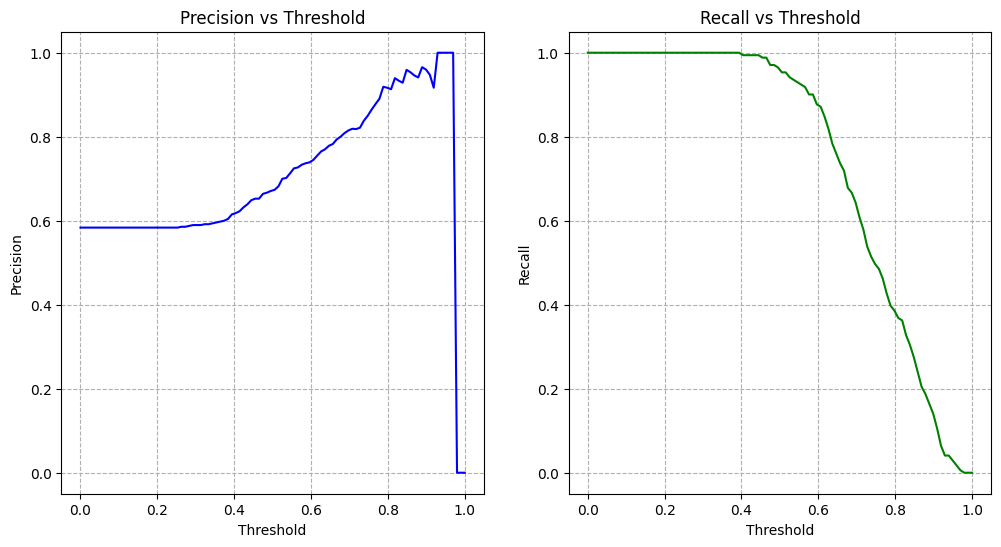

In [112]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(threshold, precisions, color='blue')
axes[0].set_title('Precision vs Threshold')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Precision')
axes[0].grid(True, linestyle='--')

axes[1].plot(threshold, recalls, color='green')
axes[1].set_title('Recall vs Threshold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Recall')
axes[1].grid(True, linestyle='--')
plt.show()


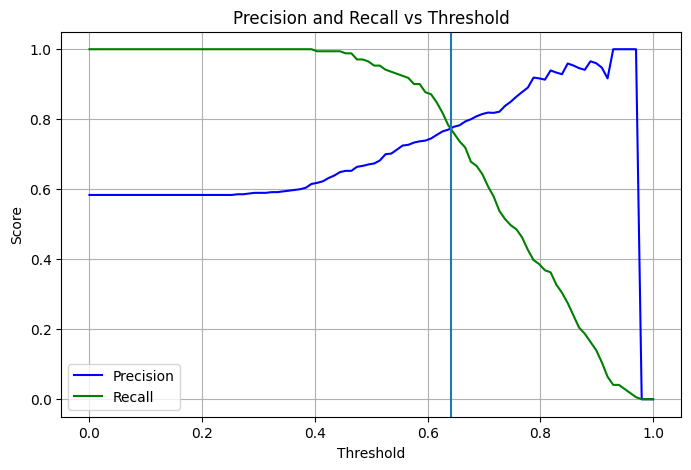

In [113]:
plt.figure(figsize=(8, 5))
plt.plot(threshold, precisions, label='Precision', color='blue')
plt.plot(threshold, recalls, label='Recall', color='green')
plt.axvline(0.641)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)  # 👈 Adds a grid to the background
plt.show()


In [114]:
# calculation the F1 score

threshold= np.linspace(0,1,100)
f1_scores =[]

for t in threshold:
    y_pred = (y_pred_prob >= t).astype(int)
    f1 = f1_score(y_val,y_pred)
    f1_scores.append(f1)


/tmp/ipykernel_29456/3782355062.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


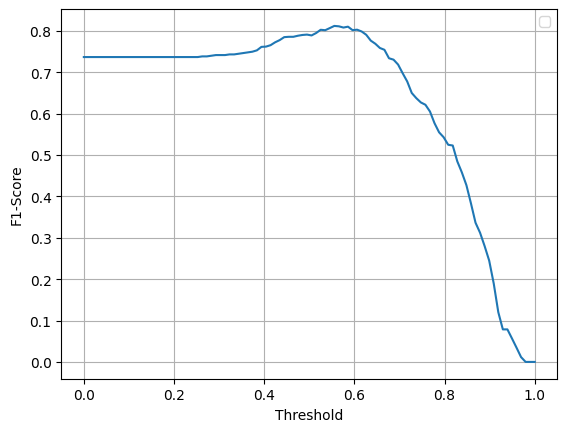

In [115]:
plt.plot(threshold, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show();

## Question 5: 5-Fold CV

In [116]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
X = train.drop(columns=['converted'])
y = train['converted']
auc_scores = []

for train_idx,val_idx in kf.split(X):
    # split the data
    X_train,X_val = X.iloc[train_idx],X.iloc[val_idx] 
    y_train,y_val = y.iloc[train_idx], y.iloc[val_idx]

    # encode using DictVictorizer
    dv = DictVectorizer(sparse=False)
    X_train_dict= X_train.to_dict(orient='records')
    X_val_dict = X_val.to_dict(orient='records')
    X_train_enc = dv.fit_transform(X_train_dict) 
    X_val_enc = dv.transform(X_val_dict)
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_val_enc)[:, 1]

    # Compute AUC
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

    print(f"Fold AUC: {auc:.3f}")



Fold AUC: 0.805
Fold AUC: 0.827
Fold AUC: 0.866
Fold AUC: 0.847
Fold AUC: 0.818


In [117]:
# calcultate the mean and standard deviation

auc_mean = np.mean(auc_scores)
auc_sd = np.std(auc_scores)
print(f"The mean : {auc_mean:.2f}")
print(f"The standard deviation : {auc_sd:.2f}")

The mean : 0.83
The standard deviation : 0.02


## Question 6: Hyperparameter Tuning

In [118]:
C_values = [0.000001, 0.001, 1]
results = []

X = train.drop(columns=['converted'])
y = train['converted']

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for c in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Encode
        dv = DictVectorizer(sparse=False)
        X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_enc = dv.transform(X_val.to_dict(orient='records'))

        # Train model
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train_enc, y_train)

        # Predict probabilities
        y_pred_proba = model.predict_proba(X_val_enc)[:, 1]

        # Compute AUC
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    # Compute mean and std
    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)
    
    results.append((c, mean_auc, std_auc))
    print(f"C: {c}, Mean AUC: {mean_auc}, Std: {std_auc}")

# Find the best C
best_C = max(results, key=lambda x: x[1])[0]
print(f"\nBest C based on mean AUC: {best_C}")

C: 1e-06, Mean AUC: 0.559, Std: 0.031
C: 0.001, Mean AUC: 0.875, Std: 0.025


C: 1, Mean AUC: 0.833, Std: 0.022

Best C based on mean AUC: 0.001
